In [1]:
import os
import pickle

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.chdir('../')
from utils.config_dataset import *

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# limit CPU cores used by the script

os.environ["OMP_NUM_THREADS"] = "32" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "32" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "32" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "32" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "32" # export NUMEXPR_NUM_THREADS=1

In [3]:
patient_info = pickle.load(open(os.path.join(path_processed, 'patient_info_valid.p'), 'rb')) 
pharma_injection = [
    1000747,
    1000658, 
    # 1000655,
]

In [4]:
patient_info

,patientid,admissiontime,sex,age,discharge_status,los,APACHE
0,1,2197-04-03 19:15:00,M,75,alive,0 days 15:31:00,Surgical Cardiovascular
1,2,2117-10-18 22:35:00,M,80,alive,8 days 08:40:00,Trauma
2,3,2163-10-17 19:15:00,M,55,alive,0 days 18:07:00,Surgical Cardiovascular
3,5,2144-06-06 16:15:00,M,20,alive,2 days 21:20:00,Trauma
4,6,2143-09-04 15:15:00,F,65,alive,0 days 19:14:00,Surgical Neurological
...,...,...,...,...,...,...,...
28308,33898,2185-08-21 22:45:00,F,75,alive,9 days 12:31:00,Neurological
28309,33899,2161-02-28 12:05:00,F,60,alive,0 days 23:15:01.920000,Sepsis
28310,33901,2119-06-15 21:55:00,M,70,alive,6 days 14:35:00,Cardiovascular
28311,33902,2182-12-12 21:20:00,F,75,alive,0 days 18:21:00,Pulmonary


# Load data samples

In [5]:
path_samples = os.path.join(path_processed, 'training_samples')

pid_dict = {pharma:set() for pharma in pharma_injection}
samples = []
sample_dict = {}

i = 0
for pharma in pharma_injection:
    print(f'--------------------{pharma}------------------')
    path_pharma_sample = os.path.join(path_samples, str(pharma))
    data_files = os.listdir(path_pharma_sample)
    for file in tqdm(data_files):
        pid = int(file.split('_')[0])
        pid_dict[pharma].add(pid)
        
        data = pickle.load(open(os.path.join(path_pharma_sample, file), 'rb'))
        data_cols = pd.MultiIndex.from_tuples(data.columns)
        data.columns = data_cols
        
        selected_cols = [('pharma_impact', 0), ('pharma', str(pharma))]\
                        + [col for col in data.columns if col[0] == 'physio_num']
        data = data.loc[:, selected_cols]

        samples.append(data.values)
        
        sample_dict[i] = {}
        sample_dict[i]['pharmaid'] = pharma
        sample_dict[i]['pid'] = pid
        sample_dict[i]['age'] = patient_info.loc[patient_info['patientid']==pid, 'age'].item()
        sample_dict[i]['sex'] = patient_info.loc[patient_info['patientid']==pid, 'sex'].item()
        sample_dict[i]['apache'] = patient_info.loc[patient_info['patientid']==pid, 'APACHE'].item()
        adm_time = patient_info.loc[patient_info['patientid']==pid, 'admissiontime'].item()
        los = patient_info.loc[patient_info['patientid']==pid, 'los'].item()
        los_curr = los - (data.index[data.shape[0]//2] - adm_time)
        sample_dict[i]['los'] = los_curr
        
        
        dischargestatus = patient_info.loc[patient_info['patientid']==pid, 'discharge_status'].item()
        if dischargestatus == 'alive':
            sample_dict[i]['survived'] = 1 
        else:
            sample_dict[i]['survived'] = 0
            
        i += 1
        
samples = np.array(samples)

len(samples)

--------------------1000747------------------


100%|█████████████████████████████████████████████████████████████| 26422/26422 [02:52<00:00, 153.06it/s]


--------------------1000658------------------


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8146/8146 [00:53<00:00, 152.36it/s]


34568

In [6]:
from sklearn.model_selection import train_test_split

pids = set()
for pharma in pid_dict:
    pids = pids.union(pid_dict[pharma])
pids = list(pids)
dischargestatus = [patient_info.loc[patient_info['patientid']==pid, 'discharge_status'].item() 
                   for pid in pids]

pid_train, pid_test= train_test_split(pids, test_size=0.2, random_state=42, stratify=dischargestatus)

In [7]:
pid_train, pid_test, y_train, y_test= train_test_split(pids, dischargestatus,
                                                       test_size=0.2, random_state=42, 
                                                       stratify=dischargestatus)

In [8]:
len(pid_train), len(pid_test), y_train.count('dead'), y_test.count('dead')

(4021, 1006, 362, 91)

In [9]:
idx_train = [i for i in sample_dict if sample_dict[i]['pid'] in pid_train]
idx_test = [i for i in sample_dict if sample_dict[i]['pid'] in pid_test]

In [79]:
data

pharma_impact  pharma physio_num                       \
                                0 1000658          1       2    18     24   
2170-03-08 21:04:00             1     0.0       95.0     NaN  79.0  149.0   
2170-03-08 21:06:00             1     0.0       95.0     NaN  79.0    NaN   
2170-03-08 21:08:00             1     0.0       95.0     NaN  79.0  145.0   
2170-03-08 21:10:00             1     0.0       95.0     NaN  79.0  144.0   
2170-03-08 21:12:00             1     0.0       95.0     NaN  79.0  136.0   
...                           ...     ...        ...     ...   ...    ...   
2170-03-09 02:56:00             1     0.0       96.5  10.825  73.0  115.0   
2170-03-09 02:58:00             1     0.0       97.0   9.000  72.0  129.0   
2170-03-09 03:00:00             1     0.0       96.0  11.000  75.0  138.0   
2170-03-09 03:02:00             1     0.0       96.0   8.800  74.0  135.0   
2170-03-09 03:04:00             1     0.0       96.0  12.000  73.0  112.0   

                                                                       
                       25    26    34          43        45        46  
2170-03-08 21:04:00  58.0  82.5   8.0   94.117645  0.103423  2.402827  
2170-03-08 21:06:00   NaN   NaN   8.0   94.117645  0.289338  2.402827  
2170-03-08 21:08:00  56.0  79.0   8.0   94.117645  0.058381  2.402827  
2170-03-08 21:10:00  60.0  83.0  12.5   94.117645  0.058381  2.402827  
2170-03-08 21:12:00   NaN  75.0   NaN   94.117645  0.058381  2.402827  
...                   ...   ...   ...         ...       ...       ...  
2170-03-09 02:56:00  46.0  65.0  13.0  158.241760  0.064029  3.087720  
2170-03-09 02:58:00  50.0  70.0  13.0  158.241760  0.064029  3.087720  
2170-03-09 03:00:00  53.0  75.0  13.0  158.241760  0.345476  3.087720  
2170-03-09 03:02:00  51.0  73.0  12.0  158.241760  0.345476  3.087720  
2170-03-09 03:04:00  46.0  60.0  11.0  158.241760  0.345476  3.087720  

[181 rows x 12 columns]

# Normalize data

In [11]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [12]:
df = []
for sample in tqdm(samples):
    df_ = pd.DataFrame(sample)
    df.append(df_)
    
df = pd.concat(df)
df = df.reset_index(drop=True)

100%|███████████████████████████████████████████████████████████████████████████████| 34568/34568 [00:01<00:00, 21144.95it/s]


In [13]:
df.aggregate(['mean', 'min', 
              percentile(0.00001), percentile(0.0001), percentile(0.001), 
              percentile(0.01), percentile(0.05), percentile(0.1),
              'median',
              percentile(0.9), percentile(0.95), percentile(0.99),
              percentile(0.999), percentile(0.9999), percentile(0.99999), 
              'max'])

,0,1,2,3,4,5,6,7,8,9,10,11
mean,0.951363,0.210857,94.962947,19.446981,90.37805,108.200624,52.449575,70.769701,12.877345,172.005974,7.664248e+00,4.613814e+00
min,0.000000,0.000000,0.000000,0.000000,0.00000,-319.360000,-319.360000,-319.360000,-319.360000,0.000000,0.000000e+00,0.000000e+00
percentile_00,0.000000,0.000000,18.054460,0.000000,0.00000,-311.425860,-310.360000,-311.360000,-318.360000,0.000000,0.000000e+00,0.000000e+00
percentile_00,0.000000,0.000000,53.000000,0.000000,34.00000,0.000000,-23.000000,0.000000,-37.000000,0.000000,0.000000e+00,0.000000e+00
percentile_00,0.000000,0.000000,73.000000,0.000000,47.00000,50.000000,22.000000,38.000000,-6.000000,0.000000,0.000000e+00,0.000000e+00
percentile_01,0.000000,0.000000,84.000000,5.500000,56.00000,62.000000,32.000000,46.000000,-1.000000,0.000000,0.000000e+00,1.730769e-01
percentile_05,1.000000,0.000000,89.000000,7.500000,65.00000,73.500000,37.000000,52.000000,2.000000,10.169492,0.000000e+00,7.492250e-01
percentile_10,1.000000,0.000000,91.000000,9.000000,70.00000,80.000000,40.000000,55.000000,4.000000,23.076923,0.000000e+00,9.126319e-01
median,1.000000,0.000000,95.000000,18.800000,90.00000,106.000000,51.000000,68.500000,9.500000,90.000000,7.166042e-02,2.074628e+00
percentile_90,1.000000,0.000000,99.000000,29.800000,111.00000,139.000000,65.000000,87.000000,16.000000,288.000000,1.123591e+00,5.040237e+00


In [14]:
valid_ranges = {
    1: [0, 1040],
    2: [0, 100],
    3: [0, 125],
    4: [0, 357],
    5: [0, 353],
    6: [0, 360],
    7: [0, 340],
    8: [-37, 361],
    9: [0, 3360],
    10:[0, 579],
    11:[0, 65]
}

In [15]:
for col in valid_ranges:
    r = valid_ranges[col]
    df.loc[(df[col] < r[0]) | (df[col] > r[1])] = np.nan
    df[col] = (df[col] - r[0]) / (r[1]-r[0])

df = df.fillna(-1)

In [16]:
samples_normed = []
grps = df.groupby(df.index // 181)

for _, dfg in tqdm(grps):
    samples_normed.append(dfg.values)
samples_normed = np.array(samples_normed)

100%|███████████████████████████████████████████████████████████████████████████████| 34568/34568 [00:00<00:00, 35703.34it/s]


In [82]:
X_train = samples_normed[idx_train]
X_test = samples_normed[idx_test]

In [107]:
os.path.abspath(path_processed)

'/home/kai/DigitalICU/Experiments/HIRID-PatientStateSpace/processed-v2'

In [108]:
training_data_injectiononly = {
    'samples_raw': samples,
    'samples_norm': samples_normed,
    'sample_dict': sample_dict,
    'idx_train': idx_train,
    'idx_test': idx_test,
    'pid_train': pid_train,
    'pid_test': pid_test,
}

pickle.dump(training_data_injectiononly, 
            open(os.path.join(path_processed, 'training_data_injectiononly.p'), 'wb'))

# PCA clustering

In [17]:
from sklearn.decomposition import KernelPCA
from sklearn.covariance import MinCovDet

def plot_pca_explained_variance(pca):
    try:
        exp_var_pca = pca.explained_variance_ratio_
    except:
        exp_var = numpy.var(kpca_transform, axis=0)
        exp_var_pca = exp_var / numpy.sum(exp_var)
    #
    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    #
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    #
    # Create the visualization plot
    #
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [60]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

labels = {label:[] for label in ['pharmaid', 'apache', 'age', 'los', 'survived']}

for k in tqdm(sample_dict):
    for label in ['pharmaid', 'apache', 'age', 'los', 'survived']:
        labels[label].append(sample_dict[k][label])
        
for label in labels:
    ll = label_encoder.fit_transform(labels[label])
    labels[label] = ll

100%|██████████████████████████████████████████████████████████████████| 34568/34568 [00:00<00:00, 461340.48it/s]


In [18]:
X = samples_normed.copy().reshape(samples_normed.shape[0], -1)

pca = KernelPCA(n_components=10, kernel='linear', n_jobs=48)
pca.fit(X)
# plot_pca_explained_variance(pca)

AttributeError: 'KernelPCA' object has no attribute 'explained_variance_ratio_'

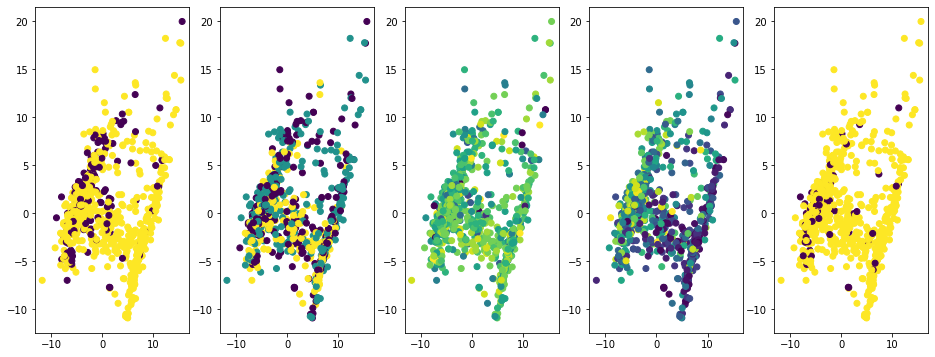

In [64]:
x_sub = np.random.choice(range(len(X)), 1000)
x_linear = pca.transform(X[x_sub])

fig, ax = plt.subplots(1, 5, figsize=(16, 6))
for i, label in enumerate(labels.keys()):
    ax[i].scatter(x_linear[:, 0], x_linear[:, 1], c=labels[label][x_sub])

In [24]:
pca_poly = KernelPCA(n_components=10, kernel='poly', n_jobs=48)
pca_poly.fit(X)
# plot_pca_explained_variance(pca_poly)

KernelPCA(kernel='poly', n_components=10, n_jobs=48)

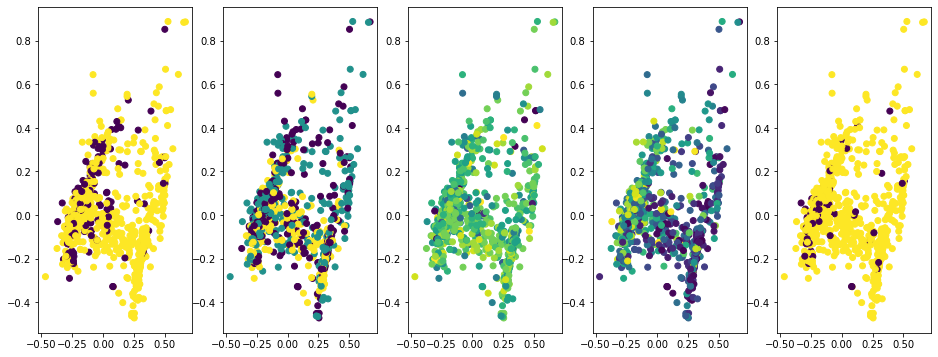

In [66]:
x_poly = pca_poly.transform(X[x_sub])

fig, ax = plt.subplots(1, 5, figsize=(16, 6))
for i, label in enumerate(labels.keys()):
    ax[i].scatter(x_poly[:, 0], x_poly[:, 1], c=labels[label][x_sub])

In [25]:
pca_rbf = KernelPCA(n_components=10, kernel='rbf', n_jobs=48)
pca_rbf.fit(X)
# plot_pca_explained_variance(pca_rbf)

KernelPCA(kernel='rbf', n_components=10, n_jobs=48)

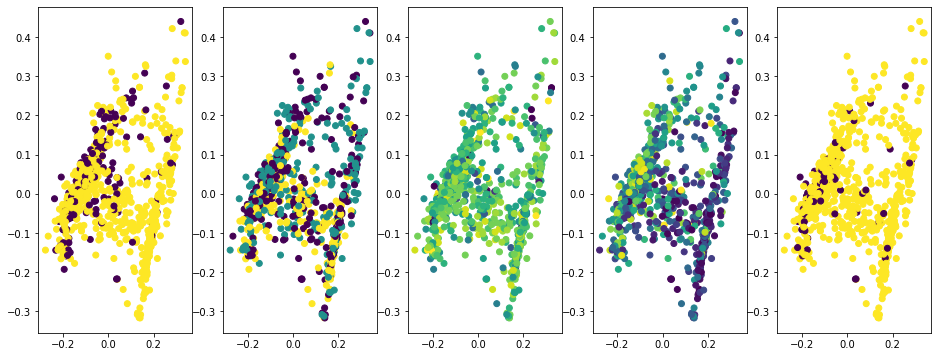

In [67]:
x_rbf = pca_rbf.transform(X[x_sub])

fig, ax = plt.subplots(1, 5, figsize=(16, 6))
for i, label in enumerate(labels.keys()):
    ax[i].scatter(x_rbf[:, 0], x_rbf[:, 1], c=labels[label][x_sub])

In [26]:
pca_sigmoid = KernelPCA(n_components=10, kernel='sigmoid', n_jobs=48)
pca_sigmoid.fit(X)
# plot_pca_explained_variance(pca_sigmoid)

KernelPCA(kernel='sigmoid', n_components=10, n_jobs=48)

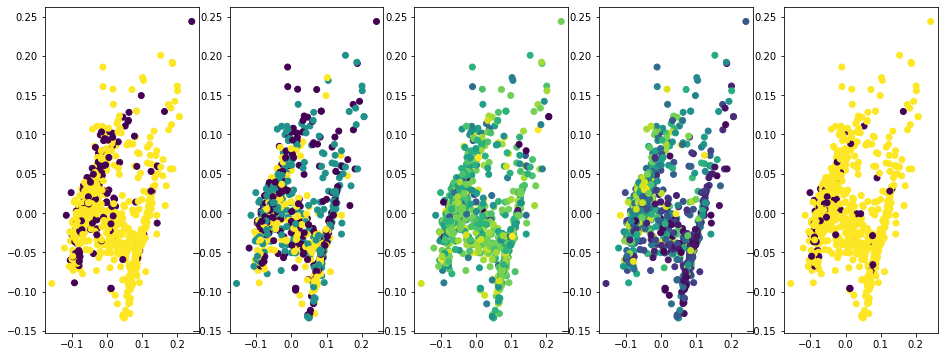

In [68]:
x_sig = pca_sigmoid.transform(X[x_sub])

fig, ax = plt.subplots(1, 5, figsize=(16, 6))
for i, label in enumerate(labels.keys()):
    ax[i].scatter(x_sig[:, 0], x_sig[:, 1], c=labels[label][x_sub])

In [27]:
pca_cosine = KernelPCA(n_components=10, kernel='cosine', n_jobs=48)
pca_cosine.fit(X)
# plot_pca_explained_variance(pca_cosine)

KernelPCA(kernel='cosine', n_components=10, n_jobs=48)

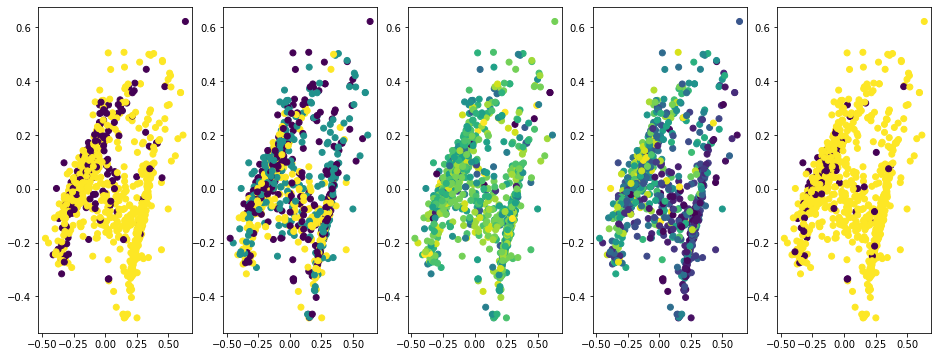

In [69]:
x_cos = pca_cosine.transform(X[x_sub])

fig, ax = plt.subplots(1, 5, figsize=(16, 6))
for i, label in enumerate(labels.keys()):
    ax[i].scatter(x_cos[:, 0], x_cos[:, 1], c=labels[label][x_sub])

# Kmeans

In [22]:
from sklearn.cluster import KMeans

scores_raw = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(X)
    scores_raw.append(kmeans.inertia_) 
    
plt.figure(figsize = (10,5))
plt.plot(scores_raw, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

NameError: name 'scores_1' is not defined

<Figure size 720x360 with 0 Axes>

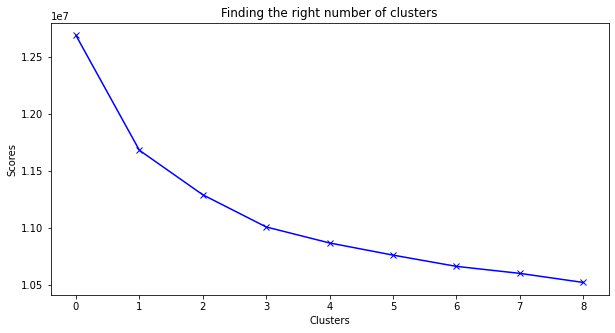

In [23]:
plt.figure(figsize = (10,5))
plt.plot(scores_raw, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

In [28]:
# choose K=3
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X)

KMeans(n_clusters=3)

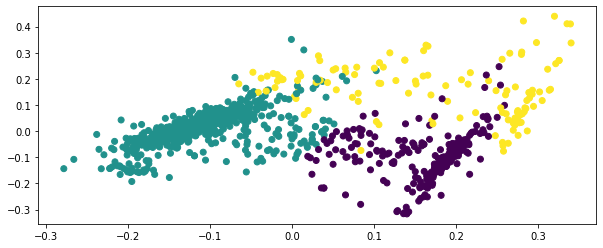

In [70]:
label_kmeans = kmeans.fit_predict(X[x_sub])

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(x_rbf[:, 0], x_rbf[:, 1], c=label_kmeans)

In [96]:
samples_normed[:5, 90, 1]

array([0.01923077, 0.03846154, 0.00961538, 0.00961538, 0.00961538])

In [92]:
samples_normed[0][:3, np.array([i for i in range(12) if i != 1])]

array([[1.00000000e+00, 9.50000000e-01, 7.84000000e-02, 2.77310924e-01,
        2.46458924e-01, 1.52777778e-01, 1.91176471e-01, 1.23115578e-01,
        1.78571429e-03, 2.87774164e-04, 1.27088667e-02],
       [1.00000000e+00, 9.50000000e-01, 7.92000000e-02, 2.77310924e-01,
        2.54957507e-01, 1.58333333e-01, 1.94117647e-01, 1.25628141e-01,
        1.78571429e-03, 2.87774164e-04, 1.27088667e-02],
       [1.00000000e+00, 9.50000000e-01, 7.84000000e-02, 2.77310924e-01,
        2.46458924e-01, 1.52777778e-01, 1.88235294e-01, 1.23115578e-01,
        1.78571429e-03, 2.87774164e-04, 1.27088667e-02]])

# Autoencoder

In [109]:
from utils.ClassAE import *
from utils.ClassDataset import *

In [127]:
X_test = samples_normed[idx_test]
dataset_test = CusDataset(X_test)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle=False, drop_last=False, num_workers=16)

In [161]:
device = 'cuda'
seq_len = 181
n_feat = 12
n_emb = 128
n_layer = 2
dropout = 0.0

config = {
    'device': device,
    "seq_len": seq_len,
    "n_feat": n_feat,
    "n_emb": n_emb,
    'n_layer': n_layer,
    "lr": 5e-3,
    "dropout": dropout,
}

model_file = 'models/2layer-128hidden-0.0dropout/version_1/epoch133-val_loss0.20293.ckpt'

model = LSTM_AE.load_from_checkpoint(checkpoint_path=model_file, config=config).to('cuda')
model.eval()

LSTM_AE(
  (encoder): LSTMEncoder(
    (lstm): LSTM(12, 128, num_layers=2, batch_first=True)
  )
  (decoder): LSTMDecoder(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
    (out): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)

In [163]:
it=iter(test_loader)
X = next(it)
X = X['data']
X_ = model(X.to('cuda'))
X_ = X_.cpu().detach().numpy()

In [165]:
X_.shape, X.shape

((16, 181, 10), torch.Size([16, 181, 12]))

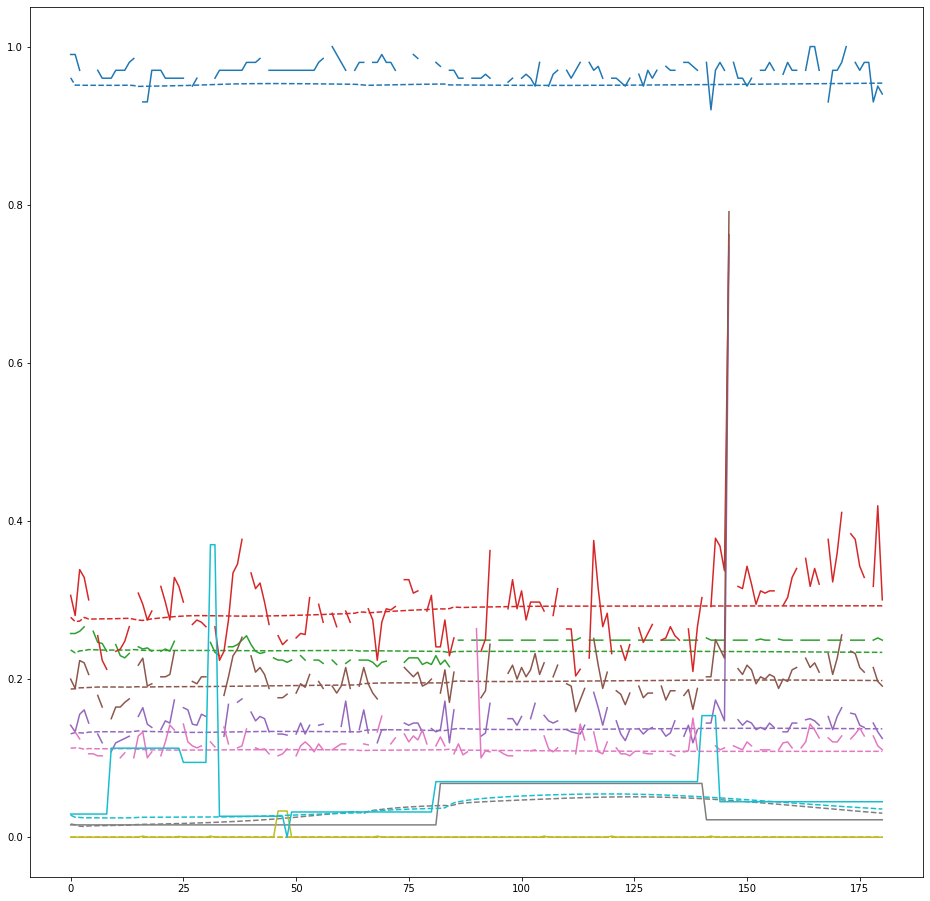

In [168]:
X[np.where(X==-1) ] = np.nan

x = X[0]
x_ = X_[0]

fig, ax = plt.subplots(1,1,figsize=(16,16))
colors = plt.cm.tab10
for j in range(10):
    ax.plot(x[:, 2+j], '-', color=colors(j))
    ax.plot(x_[:, j], '--', color=colors(j))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd87cf8adc0>
Traceback (most recent call last):
  File "/home/kai/workspace/env/py38-torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/home/kai/workspace/env/py38-torch/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 930, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


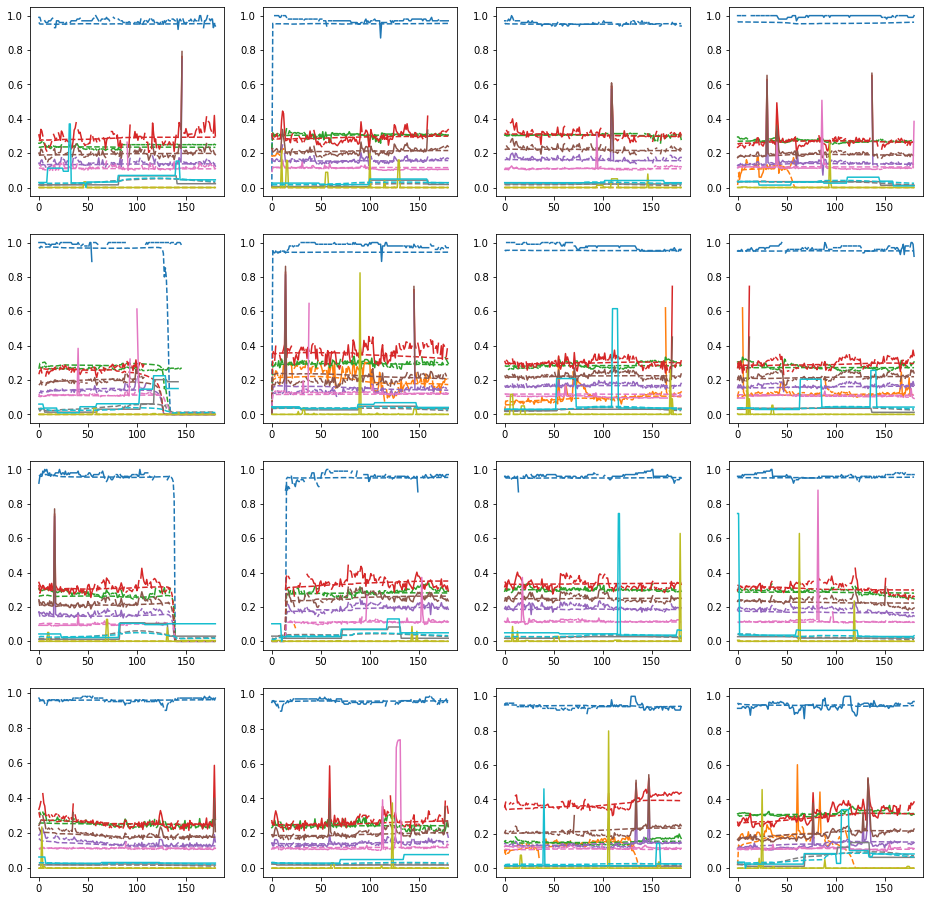

In [167]:
fig, ax = plt.subplots(4,4,figsize=(16,16))
colors = plt.cm.tab10

X[np.where(X==-1) ] = np.nan
for i, (x, x_) in enumerate(zip(X, X_)):
    for j in range(10):
        ax[i//4][i%4].plot(x[:, 2+j], '-', color=colors(j))
        ax[i//4][i%4].plot(x_[:, j], '--', color=colors(j))

In [151]:
X_ = X_.cpu().detach().numpy()

In [173]:
a = np.array([[1,2,-1],[5,-1,5]], dtype=float)
mask = np.where(a!=-1)


In [174]:
a[mask]

array([1., 2., 5., 5.])

In [175]:
b = torch.Tensor([[1,2,-1], [5,-1,5]])
mask = b!=-1

In [176]:
mask

tensor([[ True,  True, False],
        [ True, False,  True]])

In [177]:
b[mask]

tensor([1., 2., 5., 5.])